In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import importlib
from tqdm import tqdm

import sys
sys.path.append('..')
import controllers 
import env.system as system
import env.env_gym as env_gym
import utils

### Load disturbance data
Historical data have been collected from Solcast API [http://solcast.com/].     
The considered year is 2024, with 5-minutes time frequency.    
Data preprocessing focused on upsampling the variables to 15-seconds time frequency with linear interpolation.    
Considered variables:     
- $T_{amb}$: ambient or outdoor temperature [$°C$],
- $GHI$: global horizontal irradiation [$W/m^2$]. This variable has to be preprocessed to compute direct irradiation on four facades orientations $f \in F=\{N,E,W,S\}$ [https://www.research-collection.ethz.ch/server/api/core/bitstreams/61a95a4a-26f3-43e1-b236-e5a413d0fd16/content].    
For sake of simplicity an equal direct solar irradiation is assumed for each facade and calculated as:    
\begin{equation}
I_f= \frac{GHI}{|F|} \quad \forall f \in F
\end{equation}    
Thus:
\begin{equation}
v_t= (T_{amb,t} ,I_{f,t}) \quad \forall f \in F, t \in T
\end{equation}  

In [3]:
df_disturbances= pd.read_csv('disturbances//output.csv')
time= pd.to_datetime(df_disturbances['time'])
temperature= np.array(df_disturbances.loc[:,'temperature'])
raw_irrandiance= np.array(df_disturbances.loc[:,'irradiance'])
irradiances= 0.25*np.tile(raw_irrandiance,(4,1))
disturbance= np.concatenate((temperature.reshape(-1,1), irradiances.T),axis=1)

In [4]:
t0= 2000
dt= 4*60
v_hourly= disturbance[t0:t0+dt,:]
ep_time= time.iloc[t0:t0+dt]

### System
Discrete-time, bi-linear system:   
\begin{equation}
\begin{cases}
x_{t+1} = x_t + dt \left[ A x_t + B_u u_t + B_v v_t + \sum_{i=1}^{n_u} \left( B_{vu,i} v_t + B_{xu,i} x_t \right) u_{t,i} \right] 
& \forall t = 1, \ldots, T \\
x_0 = X_0
\end{cases}
\end{equation}

In [5]:
importlib.reload(system)
importlib.reload(env_gym)

############### PARAMS ##################
observation_index= 1
action_index=  12
distrubance_index= [3,4,5,6,7]
########################################

model_type= 'continuous'  # 'continuous' or 'discrete'
data_path= '../data/'     # Path to the data directory
model_data = sio.loadmat(data_path + model_type + '_time_model.mat',mat_dtype= True)
A= model_data['model'][0][0][0]
Bu= model_data['model'][0][0][1]
Bv= model_data['model'][0][0][2]
Bvu= model_data['model'][0][0][3]
Bxu= model_data['model'][0][0][4]

N= 390  # system state variable size
M= 13   # system control variable size
V= 9    # system disturbance size
No= len(observation_index) if type(observation_index) is list else 1 # observations size
Ma= len(action_index)      if type(action_index) is list else 1      # action size
V_= len(distrubance_index) if type(distrubance_index) is list else 1 # disturbance size

umin= np.array([0]).reshape((Ma,1))
umax= np.array([100]).reshape((Ma,1))
model= {}
model['A']= A
model['Bu']= Bu
model['Bv']= Bv[:,distrubance_index].reshape((N,V_))
model['Bvu']= Bvu[:,distrubance_index,:].reshape((N,V_,M))
model['Bxu']= Bxu

dt = 15                         # seconds time step
T= v_hourly.shape[0]            # Number of time steps
x_t = np.ones((No,1))*22        # Desired temperature
x0= np.ones((N,1))*20           # Initial state
v= v_hourly.T                   # Disturbances (outdoor temperature and irradiances)

# Initialize the system model and environment
system_model= system.Continuous(model, x0, x_t, v,
                              observation_index,
                              action_index,
                              dt= dt)
env_= env_gym.Env(system= system_model,
                      o_dim= No,
                      a_dim= Ma,
                      umin= umin,
                      umax= umax,
                      T=T)

#### check

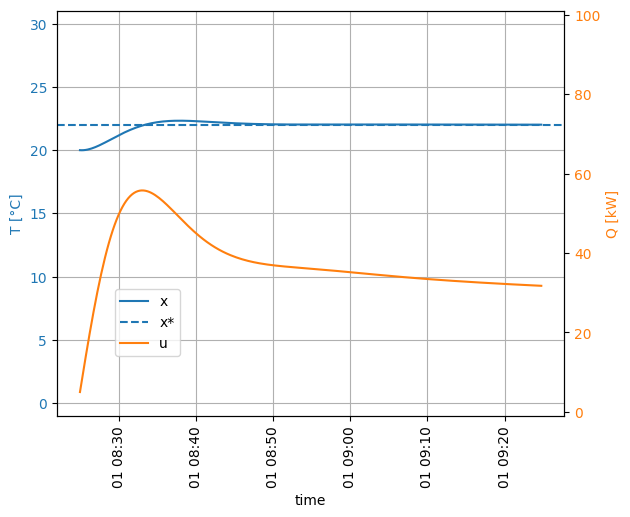

In [6]:
importlib.reload(controllers)
importlib.reload(utils)

piddino= controllers.PID(Kp= 1 , Ki= 0.1 , Kd=0.0, 
                setpoint= x_t[0][0], 
                umin= umin[0][0], 
                umax= umax[0][0], 
                dt=dt)
states, actions, rewards, sys_states= utils.pid_trajectory(env_, v, x0, piddino)
utils.plot_test(time= ep_time, states= states, x_t= x_t, actions= actions, 
                v_test= None, umin= umin-1, umax= umax+1)

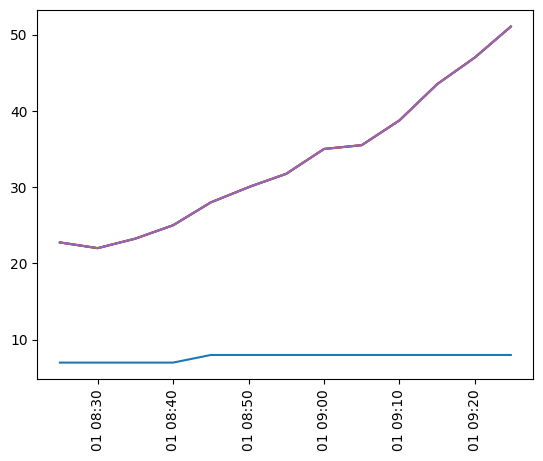

In [7]:
plt.plot(ep_time,v.T)
plt.xticks(rotation=90)
plt.show()

### Simulations
Considering a PI controller, two parameters must be tuned $K_P$ and $K_I$.    
To do that scenarios are simulated considering the possibile parameter combinations within a search space. The search space $S_k$ is a logarithmically spaced set of 10 different values from $0.1$ to $10$. Thus:   
\begin{equation}
(K_P,K_I)_k \in S_k \times S_k \nonumber
\end{equation}
For each $(K_P,K_I)_k$ a simulation long $T$ time (1 hour) is generated, and the total reward $R_k$ is calculated as:    
\begin{equation}
R_k = - \sum_t^T \left[ (e_t \ dt)^2 + 10^{-4}(u_t \ dt)^2 + e^{-|e_t|} \right] \nonumber
\end{equation}
where
\begin{equation}
e_t = x^*-x_t \nonumber
\end{equation}
Then the maximum reward is computed and $max_{R_k}(K_P,K_I)_k$ saved.

#### 1 hour

In [8]:
ks= list(np.logspace(-1,1,10))
t0= 100000
delta_t= 4*60
v= disturbance[t0:t0+delta_t,:].T

simulations_info= pd.DataFrame(columns=['Kp','Ki','Total Reward','Tracking Reward','Cost Reward','Precision Reward'])
c=-1
for k in tqdm(ks):
    for k_ in ks:
        c=c+1

        piddino= controllers.PID(Kp= k , Ki= k_ , Kd=0.0)
        states, actions, rewards, sys_states= utils.pid_trajectory(env_, v, x0, piddino)

        # if c==5:
        #     utils.plot_test(time= ep_time, states= states, x_t= x_t, actions= actions, 
        #         v_test= None, umin= umin-1, umax= umax+1)

        simulations_info.loc[c,:] = [k, k_, 
            *utils.episodic_rewards(env_.system, np.array(states), np.array(actions))]

100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


In [9]:
simulations_info

,Kp,Ki,Total Reward,Tracking Reward,Cost Reward,Precision Reward
0,0.1,0.1,-22154.872614,-13853.932401,-8096.042456,-204.897757
1,0.1,0.16681,-18973.109156,-10399.201621,-8361.737675,-212.16986
2,0.1,0.278256,-17119.756388,-8254.034386,-8649.974486,-215.747515
3,0.1,0.464159,-16183.058883,-6931.786008,-9033.546399,-217.726476
4,0.1,0.774264,-14273.922606,-4977.841725,-9073.881707,-222.199174
...,...,...,...,...,...,...
95,10.0,1.29155,-12251.355787,-3090.416674,-8931.864173,-229.074939
96,10.0,2.154435,-11706.523098,-2601.433171,-8874.04959,-231.040337
97,10.0,3.593814,-11327.89978,-2432.458637,-8662.832823,-232.608319
98,10.0,5.994843,-65274.04284,-38153.737679,-27000.0,-120.305161


#### 1 month

In [10]:
x0= np.ones((N,1))*23           

In [11]:
start_month= 0
delta_t= 4*60
time_horizon= 4*60*24
time_steps= int(time_horizon/delta_t)
tk= start_month*time_horizon

best_sim= pd.DataFrame(columns=['start-time','Kp','Ki'])
ks= list(np.logspace(-1,1,10))

j= 0
for time_step in tqdm(range(time_steps)):
    
    v= disturbance[tk:tk+delta_t,:].T
    simulations_info= pd.DataFrame(columns=['Kp','Ki','Total Reward','Tracking Reward','Cost Reward','Precision Reward'])
    c=0
    for k in ks:
        for k_ in ks:
            piddino= controllers.PID(Kp= k , Ki= k_ , Kd=0.0)
            states, actions, rewards, sys_states= utils.pid_trajectory(env_, v, x0, piddino)

            simulations_info.loc[c,:] = [k, k_, 
                *utils.episodic_rewards(env_.system, np.array(states), np.array(actions))]
            c=c+1
    
    best_sim.loc[j,['Kp','Ki']]= simulations_info.loc[simulations_info['Total Reward'].idxmax(), ['Kp','Ki']]
    best_sim.loc[j,'start-time']= time.iloc[tk]
    tk=tk+delta_t
    j=j+1

    filename= 'best_m' + str(best_sim.loc[0,'start-time'].month) + '.csv'
    if time_step%50==0:
        best_sim.to_csv(filename, index=False)

best_sim.to_csv(filename, index=False)

100%|██████████| 24/24 [04:46<00:00, 11.93s/it]


In [12]:
best_sim

,start-time,Kp,Ki
0,2024-01-01 00:05:00+00:00,0.1,0.1
1,2024-01-01 01:05:00+00:00,0.1,0.1
2,2024-01-01 02:05:00+00:00,0.1,0.1
3,2024-01-01 03:05:00+00:00,0.1,0.1
4,2024-01-01 04:05:00+00:00,0.1,0.1
5,2024-01-01 05:05:00+00:00,0.1,0.1
6,2024-01-01 06:05:00+00:00,0.1,0.1
7,2024-01-01 07:05:00+00:00,0.1,0.1
8,2024-01-01 08:05:00+00:00,0.1,0.1
9,2024-01-01 09:05:00+00:00,0.1,0.1


#### check

In [ ]:
simulations_info

In [ ]:
plt.plot(disturbance[0:time_horizon,:])
plt.xticks(rotation=90)
plt.show()

In [ ]:
utils.plot_test(time= ep_time, states= states, x_t= x_t, actions= actions, 
                v_test= None, umin= umin-1, umax= umax+1)